__File: srg_operators_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     May 17, 2019__

This notebook creates several figures showing SRG-evolved operators (other than the potential itself). This is done by constructing the unitary transformation explicitly and applying to an operator. Each function creates and saves a figure to the __Figures/SRG_operators__ folder. Below is an outline of each function:
* momentum_projection_contours - Plots contours of the momentum projection operator SRG-evolving in $\lambda$.
* momentum_projection_slices - Plots the diagonal or far off-diagonal matrix elements of the momentum projection operator SRG-evolving in $\lambda$.
* momentum_projection_integrand_contours - Plots contours of the integrand of the momentum projection operator with the deuteron wave function SRG-evolving in $\lambda$.
* momentum_projection_integrand_slices - Plots the diagonal or far off-diagonal matrix elements of the integrand of the momentum projection operator with the deuteron wave function SRG-evolving in $\lambda$.
* r2_contours - Plots contours of the radius squared operator SRG-evolving in $\lambda$. <font color=red>Work in progress.</font>

__Revision history:<br/>__
* May 29, 2019 - Updated with changes to deuteron.py, operators.py, and observables.py.
* June 3, 2019 - Added a function for generating evolved potentials, potential_contours.
* August 26, 2019 - Finalized the SRG potential and momentum projetion operator evolution figures.
* September 23, 2019 - Removed redundant functions (e.g. potential_contours which is now in srg_potentials_fig.ipynb).
* September 30, 2019 - Finalized the momentum_projection_integrand figures (contours and slices).

In [1]:
from os import chdir, getcwd
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.linalg import expm
# Scripts made by A.T.
from Figures import figures_functions as ff
from Potentials.vsrg_macos import load_save_potentials as lp
import observables as ob
import operators as op
from SRG_codes.srg_unitary_transformation import SRG_unitary_transformation

__Plotting functions__

In [2]:
def momentum_projection_contours(q, kvnn, channel, kmax, kmid, ntot, generator, lambda_array):
    """
    Plots momentum projection operator contours [fm^6] with respect to momentum [fm^-1] SRG-evolving in lambda. Must
    specify the momentum value, q, to projection onto, and details of the SRG transformation, hence the arguments
    kvnn, channel, etc. This is a 1 x 4 sub-plots figure.
    
    Parameters
    ----------
    q : float
        Momentum value in units fm^-1.
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh.
    kmid : float
        Mid-point value in the momentum mesh.
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values in units fm^-1.

    Saves
    -----
    file_name = momentum_projection_contours_ with an extension based off the given arguments. For example,
                momentum_projection_contours_q3,00_kvnn10_3S1_Block-diag.pdf.
    
    """
    
    
    # --- Set-up --- #
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    # The arrays below are used later to present a mesh-independent result
    factor_array = k_array * np.sqrt(k_weights) * np.sqrt(2/np.pi)
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Limits of axes on contours (units are fm^-1)
    if q >= 4.0:
        axes_max = 5.0
    else:
        axes_max = 4.0
        
    # Specifications of x and y axes
    # Step-size in labeling tick marks
    axes_stepsize = 1.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
        
    # Labels
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    # Label the block-diagonal Lambda
    if generator == 'Block-diag':
        lambda_label = r'$\Lambda=%.1f$' + ' fm' + r'$^{-1}$'
    # For band-diagonal generators, label lambda
    else:
        lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    generator_label = ff.generator_label_conversion(generator)
    colorbar_label = '[fm' + r'$^6$' + ']'
    
    # Fontsize for labels and tick marks
    axes_label_size = 18
    lambda_label_size = 17
    generator_label_size = 17
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18
        
    # Limits of colorbar (units are fm^6) and location of labels (dependent on specified q value)
    if q < axes_max/2:
        mx = 0.1
        mn = -0.1
        generator_label_location = 'center right'
        lambda_label_location = 'lower right'
    elif q >= 4.0:
        mx = 1e-6
        mn = -1e-6
        generator_label_location = 'upper left'
        lambda_label_location = 'lower left'
    else:
        mx = 0.01
        #mx = 0.5
        mn = -0.01
        #mn = -0.5
        generator_label_location = 'upper left'
        lambda_label_location = 'lower left'
        
    # Color scheme for contour plots
    color_style = 'jet'
    
    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # (width, height) - extra width for colorbar
    
    # File name of figure
    # This reads 'momentum_projection_contours_q_value_kvnn_number_channel_generator'
    file_name = 'momentum_projection_contours_q%.2f_kvnn%d_%s_%s' % (q, kvnn, channel, generator)

    # Current working directory
    cwd = getcwd()
        

    # --- Load data and plot contours --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over lambda values keeping track of sub-plot number i
    i = 0
    for lamb in lambda_array:
        
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        if generator == 'Block-diag':
            H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lambda_array[-1],
                                            lambda_bd=lamb)
        else:
            H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Evolved momentum projection operator
        operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix)
        # Take only the upper sub-block if coupled-channel 
        if lp.coupled_channel(channel):
            operator = operator[:ntot, :ntot]
        # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
        operator = operator / row / col
        
        # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
        # interpolated)
        k_array_int, operator_int = ff.interpolate_matrix(k_array, operator, axes_max)
    
        # Add sub-plot to figure (for last sub-plot, must specify colorbar c)
        if i != ( len(lambda_array) - 1):
            axs[i].pcolormesh(k_array_int, k_array_int, operator_int, cmap=color_style, vmin=mn, vmax=mx,
                              rasterized=True)
        else:
            c = axs[i].pcolormesh(k_array_int, k_array_int, operator_int, cmap=color_style, vmin=mn, vmax=mx,
                                  rasterized=True)
    
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(axes_ticks)
        axs[i].xaxis.set_ticklabels(axes_ticks)
        
        # Specify axes limits
        axs[i].set_xlim( (0, axes_max) )
        axs[i].set_ylim( (0, axes_max) )
        
        # Position of x-axis label and tick marks
        axs[i].xaxis.set_label_position('top')
        axs[i].xaxis.tick_top()
        axs[i].tick_params(labeltop=True, labelsize=axes_tick_size)
        
        # Prevent overlapping x-axis tick marks unless it's the last sub-plot
        if i != ( len(lambda_array) - 1 ):
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
            
        # Set axes labels
        axs[i].set_xlabel(x_label, fontsize=axes_label_size)
        # Only specify y axis tick marks, set label, and add generator label as anchored text for 1st sub-plot
        if i == 0:
            axs[i].yaxis.set_ticks(axes_ticks)
            axs[i].yaxis.set_ticklabels(axes_ticks)
            axs[i].set_ylabel(y_label, fontsize=axes_label_size)
            generator_anchored_text = AnchoredText(generator_label, prop=dict(size=generator_label_size),
                                                   loc=generator_label_location)
            axs[i].add_artist(generator_anchored_text)
            
        # Add lambda label as anchored text
        lambda_anchored_text = AnchoredText(lambda_label % lambda_array[i], prop=dict(size=lambda_label_size),
                                            loc=lambda_label_location)
        axs[i].add_artist(lambda_anchored_text)
            
        i += 1
    

    # --- Set figure specifications and save --- #

    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
    # Add colorbar and set tick size
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/SRG_operators')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [3]:
def momentum_projection_slices(line, q, channel, lambda_array, *transformations):
    """
    Plots the momentum projection operators [fm^6] with respect to momentum [fm^-1] SRG-evolving in lambda isolating
    either the diagonal or far off-diagonal matrix elements. Must specify the momentum value, q, to projection onto, 
    the partial wave channel, lambda values, and each SRG transformation of interest. Here, we compare the Wegner
    generator at the different lambda values to the block-diagonal generator at Lambda_BD = lambda (Wegner) and
    fixing lambda (block diagonal) to the last value of lambda in lambda_array. This is a 1 x 4 sub-plots figure.
    
    Parameters
    ----------
    line : str
        The slice of V(k, k') 'diag' or 'off-diag'.
    q : float
        Momentum value in units fm^-1.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    lambda_array : 1-D ndarray
        Lambda evolution values in units fm^-1. These values will also be used as Lambda_BD values for the block-
        diagonal generator.
    *transformations : tuple
        Specifications for SRG transformations in the format (kvnn, kmax, kmid, ntot) where kvnn (int) is the number
        specifying the potential, kmax (float) is the maximum value in the momentum mesh, kmid (float) is the
        mid-point value in the mesh, and ntot (int) is the number of points in the mesh. For example,
        (222, 10.0, 2.0, 120) corresponds to the default Gezerlis et al. N2LO potential.

    Saves
    -----
    file_name = momentum_projection_ with an extension based off the given arguments. For example,
                momentum_projection_diags_q3,00_3S1_kvnns_10_106_222_lamb1,0.pdf.
    
    """
    
    
    # Check that at least one transformation was provided
    if not transformations: 
        print('At least one SRG transformation must be specified.')
        return None

    
    # --- Set-up --- #
    
    # Limits of x and y axes and location of legend (dependent on q value)
    if q >= 4.0:
        xlim = [0.0, 5.0]
        ylim = [-1e-6, 1e-5]
        legend_label_location = 'upper left'
    elif q <= 2.0:
        xlim = [0.0, 4.0]
        ylim = [-0.025, 0.1]
        legend_label_location = 'upper right'
    else:
        xlim = [0.0, 4.0]
        ylim = [-0.0025, 0.01]
        legend_label_location = 'upper left'
        
    # Labels
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    if line == 'diag':
        y_label = r'$a^{\dagger}_q a_q(k,k)$' + ' [fm' + r'$^6$' + ']'
    elif line == 'off-diag':
        y_label = r'$a^{\dagger}_q a_q(k,0)$' + ' [fm' + r'$^6$' + ']'
    # Label for lambda and Lambda_BD
    lambda_label = r'$\lambda$' + ', ' + r'$\Lambda=%.1f$' + ' fm' + r'$^{-1}$'
    
    # Fontsize for labels and tick marks
    x_label_size = 18
    y_label_size = 20
    legend_label_size = 14
    lambda_label_size = 17
    
    # Location of labels
    lambda_label_location = 'lower left'
    
    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Initialize file name of figure
    # This reads 'momentum_projection_line_q_value_channel_kvnns'
    file_name = 'momentum_projection_%s_q%.2f_%s_kvnns' % (line, q, channel)
    # These lists will keep track of kvnn numbers and generators to be added to the file name
    kvnn_list = []

    # Current working directory
    cwd = getcwd()


    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over SRG-evolved potentials starting with the generator
    for generator in ['Wegner', 'Block-diag']:
        # Next potential specifications
        for transformation in transformations:
        
            # Set kvnn, kmax, kmid, ntot, and generator
            kvnn = transformation[0]
            kmax = transformation[1]
            kmid = transformation[2]
            ntot = transformation[3]
        
            # Keep track of kvnn numbers for file name at the end
            if kvnn not in kvnn_list:
                kvnn_list.append(kvnn)
            
            # Load initial Hamiltonian and momentum
            H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
            k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
            # The arrays below are used to present a mesh-independent result
            factor_array = k_array * np.sqrt(k_weights) * np.sqrt(2/np.pi)
            row, col = np.meshgrid(factor_array, factor_array)
        
            # Curve labels and styles
            
            # Curve color depends on potential
            if kvnn in [10, 900]:
                curve_color = 'xkcd:black'
            elif kvnn in [105, 106, 107, 110, 111, 112, 901]:
                curve_color = 'xkcd:red'
            elif kvnn in [222, 224, 902]:
                curve_color = 'xkcd:blue'
                
            # Curve style depends on band- or block-diagonal generator
            # Put potential label on 1st sub-plot
            if generator == 'Block-diag':
                curve_style = 'dashdot'
                potential_label = '' # No need to redundantly label the potentials
            else:
                curve_style = 'solid'
                potential_label = ff.kvnn_label_conversion(kvnn) # Legend label on 1st sub-plot
                
            # Put generator label on last sub-plot
            if kvnn == kvnn_list[0]:
                generator_label = ff.generator_label_conversion(generator)
            else:
                generator_label = '' # No need to redundantly label generators
        
            # Loop over lambda
            i = 0 # Sub-plot number
            for lamb in lambda_array:

                # Load unitary transformations
                # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
                if generator == 'Block-diag':
                    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator,
                                                    lambda_array[-1], lambda_bd=lamb)
                else:
                    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                    
                # Calculate the unitary transformation
                U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
                # Evolved momentum projection operator
                operator_matrix = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix)
                # Take only the upper sub-block if coupled-channel 
                if lp.coupled_channel(channel):
                    operator_matrix = operator_matrix[:ntot, :ntot]
                # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
                operator_matrix = operator_matrix / row / col
                    
                # Take a slice of the operator to plot
                if line == 'diag':
                    operator_vector = np.diag(operator_matrix)
                elif line == 'off-diag':
                    operator_vector = operator_matrix[:, 0]
 
                # Add sub-plot to figure
                if i == 0: # 1st sub-plot - label potential
                    axs[i].plot(k_array, operator_vector, color=curve_color, linestyle=curve_style,
                                label=potential_label)
                elif i == ( len(lambda_array) - 1 ): # Last sub-plot - label generator
                    axs[i].plot(k_array, operator_vector, color=curve_color, linestyle=curve_style,
                                label=generator_label)
                else: # Middle sub-plots - no labels
                    axs[i].plot(k_array, operator_vector, color=curve_color, linestyle=curve_style)
                
                i += 1
        
        
    # --- Set figure specifications and save --- #
    
    # Loop over sub-plots
    for j in range( len(lambda_array) ):
        
        # Specify axes limits
        axs[j].set_xlim(xlim)
        axs[j].set_ylim(ylim)
        
        # Prevent overlapping x-axis tick marks unless it's the last sub-plot
        if j != ( len(lambda_array) - 1 ):
            xticks = axs[j].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
            
        # Set axes labels
        axs[j].set_xlabel(x_label, fontsize=x_label_size)
        
        # Only specify y label and potential labels as legend for 1st sub-plot
        if j == 0:
            # Add y label
            axs[j].set_ylabel(y_label, fontsize=y_label_size)
            # Add legend for potentials
            axs[j].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
            
        # Specify generator labels as legend for last sub-plot
        if j == ( len(lambda_array) - 1 ):
            # Add legend for potentials
            axs[j].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
            
        # Add lambda's label as anchored text
        lambda_anchored_text = AnchoredText(lambda_label % lambda_array[j], prop=dict(size=lambda_label_size),
                                            loc=lambda_label_location, frameon=False)
        # Add lambda
        axs[j].add_artist(lambda_anchored_text)
    
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    
    # Name of the file
    for kvnn in kvnn_list:
        file_name += '_%d' % kvnn
    # Add last value of lambda to file name
    file_name += '_lamb%.1f' % lambda_array[-1]
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/SRG_operators')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [4]:
def momentum_projection_integrand_contours(q, kvnn, kmax, kmid, ntot, generator, lambda_array):
    """
    Plots matrix elements of the momentum projection operator with the deuteron wave function [fm^9] with respect to
    momentum [fm^-1] SRG-evolving the operator and wave function in lambda. Must specify the momentum value, q, to
    projection onto, and details of the SRG transformation, hence the arguments kvnn, generator, etc. This is a 
    1 x 4 sub-plots figure.
    
    Parameters
    ----------
    q : float
        Momentum value in units fm^-1.
    kvnn : int
        This number specifies the potential.
    kmax : float
        Maximum value in the momentum mesh.
    kmid : float
        Mid-point value in the momentum mesh.
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values in units fm^-1.

    Saves
    -----
    file_name = momentum_projection_integrand_contours_ with an extension based off the given arguments. For
                example, momentum_projection_integrand_contours_q3,00_kvnn10_Block-diag.pdf.
    
    """
    
    
    # --- Set-up --- #
    
    # Channel is 3S1 - 3D1 for deuteron
    channel = '3S1'
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    # The arrays below are used later to present a mesh-independent result
    factor_array = k_array * np.sqrt(k_weights) * np.sqrt(2/np.pi)
    # Double the size of factor array for coupled-channel
    factor_array = np.concatenate( (factor_array, factor_array) )
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Limits of axes on contours (units are fm^-1)
    if q >= 4.0:
        axes_max = 5.0
    else:
        axes_max = 4.0
    
    # Specifications of x and y axes
    # Step-size in labeling tick marks
    axes_stepsize = 1.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    
    # Labels
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    # Label the block-diagonal Lambda
    if generator == 'Block-diag':
        lambda_label = r'$\Lambda=%.1f$' + ' fm' + r'$^{-1}$'
    # For band-diagonal generators, label lambda
    else:
        lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    generator_label = ff.generator_label_conversion(generator)
    colorbar_label = '[fm' + r'$^9$' + ']'
    
    # Fontsize for labels and tick marks
    axes_label_size = 18
    lambda_label_size = 17
    generator_label_size = 17
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18
    
    # Limits of colorbar (units are fm^9) and location of labels (dependent on specified q value)
    if q < axes_max/2:
        mx = 1e-1
        mn = 1e-7
        generator_label_location = 'center right'
    else:
        mx = 1e-2
        mn = 1e-8
        generator_label_location = 'upper right'
    lambda_label_location = 'lower center'
    
    # Color scheme for contour plots
    color_style = 'Blues'
    
    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # (width, height) - extra width for colorbar
    
    # File name of figure
    # This reads 'momentum_projection_integrand_contours_q_value_kvnn_number_generator'
    file_name = 'momentum_projection_integrand_contours_q%.2f_kvnn%d_%s' % (q, kvnn, generator)

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot contours --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over lambda values keeping track of sub-plot number i
    i = 0
    for lamb in lambda_array:
        
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        if generator == 'Block-diag':
            H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lambda_array[-1],
                                            lambda_bd=lamb)
        else:
            H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Evolved momentum projection operator divided by k_i * k_j * sqrt( w_i * w_j ) for 
        # mesh-independent result
        operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix) / row / col
        
        # Load evolved wave functions and divide out momentum and weights
        psi = ob.wave_function(H_initial, eps=-2.22, U=U_matrix) / factor_array * np.sqrt(2/np.pi)
        # Mesh-grids of psi
        psi_row, psi_col = np.meshgrid(psi, psi)
        
        # Matrix elements of < psi | a^dagger_q a_q | psi >
        integrand = psi_row * operator * psi_col
        
        # Re-size to S-S block
        integrand = integrand[:ntot, :ntot]
        # For log plot take absolute value
        integrand = abs(integrand)
        
        # Interpolate the integrand through 0 to axes_max for smoother looking figure (the extension _int means 
        # interpolated)
        k_array_int, integrand_int = ff.interpolate_matrix(k_array, integrand, axes_max)

        # Add sub-plot to figure (for last sub-plot, must specify colorbar c)
        if i != ( len(lambda_array) - 1):
            axs[i].pcolormesh(k_array_int, k_array_int, integrand_int, cmap=color_style,
                              norm=colors.LogNorm(vmin=mn, vmax=mx), rasterized=True)
        else:
            c = axs[i].pcolormesh(k_array_int, k_array_int, integrand_int, cmap=color_style,
                                  norm=colors.LogNorm(vmin=mn, vmax=mx), rasterized=True)
    
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(axes_ticks)
        axs[i].xaxis.set_ticklabels(axes_ticks)
        
        # Specify axes limits
        axs[i].set_xlim( (0, axes_max) )
        axs[i].set_ylim( (0, axes_max) )
        
        # Position of x-axis label and tick marks
        axs[i].xaxis.set_label_position('top')
        axs[i].xaxis.tick_top()
        axs[i].tick_params(labeltop=True, labelsize=axes_tick_size)
        
        # Prevent overlapping x-axis tick marks unless it's the last sub-plot
        if i != ( len(lambda_array) - 1 ):
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
            
        # Set axes labels
        axs[i].set_xlabel(x_label, fontsize=axes_label_size)
        # Only specify y axis tick marks and set label for 1st sub-plot 
        if i == 0:
            axs[i].yaxis.set_ticks(axes_ticks)
            axs[i].yaxis.set_ticklabels(axes_ticks)
            axs[i].set_ylabel(y_label, fontsize=axes_label_size)
        # Add generator label as anchored text for last sub-plot
        if i == ( len(lambda_array) - 1 ):
            generator_anchored_text = AnchoredText(generator_label, prop=dict(size=generator_label_size),
                                                   loc=generator_label_location)
            axs[i].add_artist(generator_anchored_text)
            
        # Add lambda label as anchored text
        lambda_anchored_text = AnchoredText(lambda_label % lambda_array[i], prop=dict(size=lambda_label_size),
                                            loc=lambda_label_location)
        axs[i].add_artist(lambda_anchored_text)
            
        i += 1  
    

    # --- Set figure specifications and save --- #
    
    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
    # Add colorbar and set tick size
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/SRG_operators')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [5]:
def momentum_projection_integrand_slices(line, q, lambda_array, *transformations):
    """
    Plots matrix elements of the momentum projection operator with the deuteron wave function [fm^9] with respect to
    momentum [fm^-1] SRG-evolving the operator and wave function in lambda isolating either the diagonal or far 
    off-diagonal matrix elements. Must specify the momentum value, q, to projection onto, lambda values, and each 
    SRG transformation of interest. Here, we compare the Wegner generator at the different lambda values to the
    block-diagonal generator at Lambda_BD = lambda (Wegner) and fixing lambda (block diagonal) to the last value of
    lambda in lambda_array. This is a 1 x 4 sub-plots figure.
    
    Parameters
    ----------
    line : str
        The slice of V(k, k') 'diag' or 'off-diag'.
    q : float
        Momentum value in units fm^-1.
    lambda_array : 1-D ndarray
        Lambda evolution values in units fm^-1. These values will also be used as Lambda_BD values for the block-
        diagonal generator.
    *transformations : tuple
        Specifications for SRG transformations in the format (kvnn, kmax, kmid, ntot) where kvnn (int) is the number
        specifying the potential, kmax (float) is the maximum value in the momentum mesh, kmid (float) is the
        mid-point value in the mesh, and ntot (int) is the number of points in the mesh. For example,
        (222, 10.0, 2.0, 120) corresponds to the default Gezerlis et al. N2LO potential.

    Saves
    -----
    file_name = momentum_projection_integrand_ with an extension based off the given arguments. For example,
                momentum_projection_integrand_diag_q3,00_kvnns_10_106_222_lamb1,5.pdf.
    
    """
    
    
    # Check that at least one transformation was provided
    if not transformations: 
        print('At least one SRG transformation must be specified.')
        return None
    
    
    # --- Set-up --- #
    
    # Channel is 3S1 - 3D1 for deuteron
    channel = '3S1'
    
    # Limits of x and y axes and location of legend (dependent on q value)
    if q >= 4.0:
        xlim = [0.0, 4.5]
        ylim = [1e-8, 1e1]
        legend_label_location = 'center right'
    elif q <= 2.0:
        xlim = [0.0, 4.5]
        ylim = [1e-6, 1e3]
        legend_label_location = 'lower right'
    else:
        xlim = [0.0, 4.5]
        ylim = [1e-8, 1e1]
        legend_label_location = 'center right'
        
    # Labels
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    if line == 'diag':
        y_label = r'$\psi^{\dagger}_d(k) a^{\dagger}_q a_q(k,k) \psi_d(k)$' + ' [fm' + r'$^9$' + ']'
    elif line == 'off-diag':
        y_label = r'$\psi^{\dagger}_d(k) a^{\dagger}_q a_q(k,0) \psi_d(0)$' + ' [fm' + r'$^9$' + ']'
    # Label for lambda and Lambda_BD
    lambda_label = r'$\lambda$' + ', ' + r'$\Lambda=%.1f$' + ' fm' + r'$^{-1}$'
    
    # Fontsize for labels and tick marks
    x_label_size = 18
    y_label_size = 17
    legend_label_size = 14
    lambda_label_size = 17
    
    # Location of labels
    lambda_label_location = 'upper right'
    
    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Initialize file name of figure
    # This reads 'momentum_projection_integrand_line_q_value_kvnns'
    file_name = 'momentum_projection_integrand_%s_q%.2f_kvnns' % (line, q)
    # These lists will keep track of kvnn numbers and generators to be added to the file name
    kvnn_list = []

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over SRG-evolved potentials starting with the generator
    #for generator in ['Wegner', 'Block-diag']:
    # TESTING
    for generator in ['Wegner']:
        # Next potential specifications
        for transformation in transformations:
        
            # Set kvnn, kmax, kmid, ntot, and generator
            kvnn = transformation[0]
            kmax = transformation[1]
            kmid = transformation[2]
            ntot = transformation[3]
        
            # Keep track of kvnn numbers for file name at the end
            if kvnn not in kvnn_list:
                kvnn_list.append(kvnn)
    
            # Load initial Hamiltonian, momentum, and weights
            H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
            k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
            # The arrays below are used later to present a mesh-independent result
            factor_array = k_array * np.sqrt(k_weights) * np.sqrt(2/np.pi)
            # Double the size of factor array for coupled-channel
            factor_array = np.concatenate( (factor_array, factor_array) )
            row, col = np.meshgrid(factor_array, factor_array)
            
            # Curve labels and styles
            
            # Curve color depends on potential
            if kvnn in [10, 900]:
                curve_color = 'xkcd:black'
            elif kvnn in [105, 106, 107, 110, 111, 112, 901]:
                curve_color = 'xkcd:red'
            elif kvnn in [222, 224, 902]:
                curve_color = 'xkcd:blue'
                
            # Curve style depends on band- or block-diagonal generator
            # Put potential label on 1st sub-plot
            if generator == 'Block-diag':
                curve_style = 'dashdot'
                potential_label = '' # No need to redundantly label the potentials
            else:
                curve_style = 'solid'
                potential_label = ff.kvnn_label_conversion(kvnn) # Legend label on 1st sub-plot
                
            # Put generator label on last sub-plot
            if kvnn == kvnn_list[0]:
                generator_label = ff.generator_label_conversion(generator)
            else:
                generator_label = '' # No need to redundantly label generators
                
            # Loop over lambda
            i = 0 # Sub-plot number
            for lamb in lambda_array:

                # Load unitary transformations
                # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
                if generator == 'Block-diag':
                    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator,
                                                    lambda_array[-1], lambda_bd=lamb)
                else:
                    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                    
                # Calculate the unitary transformation
                U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
                # Evolved momentum projection operator divided by k_i * k_j * sqrt( w_i * w_j ) for 
                # mesh-independent result
                operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix) / row / col
        
                # Load evolved wave functions and divide out momentum and weights
                psi = ob.wave_function(H_initial, eps=-2.22, U=U_matrix) / factor_array * np.sqrt(2/np.pi)
                # Mesh-grids of psi
                psi_row, psi_col = np.meshgrid(psi, psi)
        
                # Matrix elements of < psi | a^dagger_q a_q | psi >
                integrand_matrix = psi_row * operator * psi_col
                    
                # Take a slice of the operator to plot
                if line == 'diag':
                    integrand_vector = np.diag(integrand_matrix)[:ntot]
                elif line == 'off-diag':
                    integrand_vector = integrand_matrix[:ntot, 0]
 
                # Add sub-plot to figure
                if i == 2: # 3rd sub-plot - label generator
                    axs[i].semilogy(k_array, integrand_vector, color=curve_color, linestyle=curve_style,
                                    label=generator_label)
                elif i == ( len(lambda_array) - 1 ): # Last sub-plot - label potential
                    axs[i].semilogy(k_array, integrand_vector, color=curve_color, linestyle=curve_style,
                                    label=potential_label)
                else: # Other sub-plots - no labels
                    axs[i].semilogy(k_array, integrand_vector, color=curve_color, linestyle=curve_style)
                
                i += 1
    

    # --- Set figure specifications and save --- #
    
    # Loop over sub-plots
    for j in range( len(lambda_array) ):
        
        # Specify axes limits
        axs[j].set_xlim(xlim)
        axs[j].set_ylim(ylim)
        
        # Prevent overlapping x-axis tick marks unless it's the last sub-plot
        if j != ( len(lambda_array) - 1 ):
            xticks = axs[j].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
            
        # Set axes labels
        axs[j].set_xlabel(x_label, fontsize=x_label_size)
        
        # Only specify y label for 1st sub-plot
        if j == 0:
            # Add y label
            axs[j].set_ylabel(y_label, fontsize=y_label_size)
            
        # Specify generator and potential labels as legends for 3rd and last sub-plot
        if j == 2 or j == ( len(lambda_array) - 1 ):
            # Add legend for generators
            axs[j].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
            
        # Add lambda's label as anchored text
        lambda_anchored_text = AnchoredText(lambda_label % lambda_array[j], prop=dict(size=lambda_label_size),
                                            loc=lambda_label_location, frameon=False)
        # Add lambda
        axs[j].add_artist(lambda_anchored_text)
    
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    
    # Name of the file
    for kvnn in kvnn_list:
        file_name += '_%d' % kvnn
    # Add last value of lambda to file name
    file_name += '_lamb%.1f' % lambda_array[-1]
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/SRG_operators')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [6]:
# Work in progress
def momentum_projection_slices_vary_q(line, q_array, channel, lamb, *transformations):
    """
    Plots the momentum projection operators [fm^6] with respect to momentum [fm^-1] SRG-evolving in lambda isolating
    either the diagonal or far off-diagonal matrix elements. Must specify the momentum values, q_array, to 
    project onto, the partial wave channel, the lambda value, and each SRG transformation of interest. This is a
    1 x 4 sub-plots figure.
    
    Parameters
    ----------
    line : str
        The slice of V(k, k') 'diag' or 'off-diag'.
    q_values : 1-D ndarray
        Momentum values in units fm^-1.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    lamb : float
        Lambda evolution value in units fm^-1.
    *transformations : tuple
        Specifications for SRG transformations in the format (kvnn, kmax, kmid, ntot) where kvnn (int) is the number
        specifying the potential, kmax (float) is the maximum value in the momentum mesh, kmid (float) is the
        mid-point value in the mesh, and ntot (int) is the number of points in the mesh. For example,
        (222, 10.0, 2.0, 120) corresponds to the default Gezerlis et al. N2LO potential.

    Saves
    -----
    file_name = momentum_projection_ with an extension based off the given arguments. For example,
                momentum_projection_diags_q3,00_3S1_kvnns_10_106_222_lamb1,0.pdf.
    Testing: just using plt.show() atm
    
    """
    
    
    # Check that at least one transformation was provided
    if not transformations: 
        print('At least one SRG transformation must be specified.')
        return None

    
    # --- Set-up --- #
    
    # Limits of x and y axes and location of legend (dependent on q value)
    xlim = [0.0, 4.5]
    ylim = [-0.015, 0.06]
        
    # Labels
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    if line == 'diag':
        y_label = r'$a^{\dagger}_q a_q(k,k)$' + ' [fm' + r'$^6$' + ']'
    elif line == 'off-diag':
        y_label = r'$a^{\dagger}_q a_q(k,0)$' + ' [fm' + r'$^6$' + ']'
    # Label for q values
    q_label = 'q=%.2f fm' + r'$^{-1}$'
    
    # Fontsize for labels and tick marks
    x_label_size = 18
    y_label_size = 20
    legend_label_size = 14
    q_label_size = 17
    
    # Location of labels
    q_label_location = 'lower left'
    legend_label_location = 'upper right'
    
    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Initialize file name of figure
    # This reads 'momentum_projection_line_q_value_channel_kvnns'
    file_name = 'momentum_projection_%s_q%.2f_%s_kvnns' % (line, q_array[-1], channel)
    # These lists will keep track of kvnn numbers and generators to be added to the file name
    kvnn_list = []

    # Current working directory
    cwd = getcwd()


    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over SRG-evolved potentials starting with the generator
    for generator in ['Wegner', 'Block-diag']:
        # Next potential specifications
        for transformation in transformations:
        
            # Set kvnn, kmax, kmid, ntot, and generator
            kvnn = transformation[0]
            kmax = transformation[1]
            kmid = transformation[2]
            ntot = transformation[3]
        
            # Keep track of kvnn numbers for file name at the end
            if kvnn not in kvnn_list:
                kvnn_list.append(kvnn)
            
            # Load initial Hamiltonian and momentum
            H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
            k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
            # The arrays below are used to present a mesh-independent result
            factor_array = k_array * np.sqrt(k_weights) * np.sqrt(2/np.pi)
            row, col = np.meshgrid(factor_array, factor_array)
        
            # Curve labels and styles
            
            # Curve color depends on potential
            if kvnn in [10, 900]:
                curve_color = 'xkcd:black'
            elif kvnn in [105, 106, 107, 110, 111, 112, 901]:
                curve_color = 'xkcd:red'
            elif kvnn in [222, 224, 902]:
                curve_color = 'xkcd:blue'
                
            # Curve style depends on band- or block-diagonal generator
            # Put potential label on 1st sub-plot
            if generator == 'Block-diag':
                curve_style = 'dashdot'
                potential_label = '' # No need to redundantly label the potentials
            else:
                curve_style = 'solid'
                potential_label = ff.kvnn_label_conversion(kvnn) # Legend label on 1st sub-plot
                
            # Put generator label on last sub-plot
            if kvnn == kvnn_list[0]:
                generator_label = ff.generator_label_conversion(generator)
            else:
                generator_label = '' # No need to redundantly label generators
        
            # Loop over q
            i = 0 # Sub-plot number
            for q in q_array:

                # Load unitary transformations
                # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
                if generator == 'Block-diag':
                    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb,
                                                    lambda_bd=lamb)
                else:
                    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
                    
                # Calculate the unitary transformation
                U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
                # Evolved momentum projection operator
                operator_matrix = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix)
                # Take only the upper sub-block if coupled-channel 
                if lp.coupled_channel(channel):
                    operator_matrix = operator_matrix[:ntot, :ntot]
                # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
                operator_matrix = operator_matrix / row / col
                    
                # Take a slice of the operator to plot
                if line == 'diag':
                    operator_vector = np.diag(operator_matrix)
                elif line == 'off-diag':
                    operator_vector = operator_matrix[:, 0]
 
                # Add sub-plot to figure
                if i == 0: # 1st sub-plot - label potential
                    axs[i].plot(k_array, operator_vector, color=curve_color, linestyle=curve_style,
                                label=potential_label)
                elif i == 2: # Third sub-plot - label generator
                    axs[i].plot(k_array, operator_vector, color=curve_color, linestyle=curve_style,
                                label=generator_label)
                else: # Middle sub-plots - no labels
                    axs[i].plot(k_array, operator_vector, color=curve_color, linestyle=curve_style)
                
                i += 1
        
        
    # --- Set figure specifications and save --- #
    
    # Loop over sub-plots
    for j in range( len(q_array) ):
        
        # Specify axes limits
        axs[j].set_xlim(xlim)
        axs[j].set_ylim(ylim)
        
        # Prevent overlapping x-axis tick marks unless it's the last sub-plot
        if j != ( len(q_array) - 1 ):
            xticks = axs[j].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
            
        # Set axes labels
        axs[j].set_xlabel(x_label, fontsize=x_label_size)
        
        # Only specify y label and potential labels as legend for 1st sub-plot
        if j == 0:
            # Add y label
            axs[j].set_ylabel(y_label, fontsize=y_label_size)
            # Add legend for potentials
            axs[j].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
            
        # Specify generator labels as legend for 3rd sub-plot
        if j == 2:
            # Add legend for potentials
            axs[j].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
            
        # Add q label as anchored text
        q_anchored_text = AnchoredText(q_label % q_array[j], prop=dict(size=q_label_size), loc=q_label_location,
                                       frameon=False)
        axs[j].add_artist(q_anchored_text)
    
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    
    # Name of the file
    for kvnn in kvnn_list:
        file_name += '_%d' % kvnn
    # Add lambda to file name
    file_name += '_lamb%.1f' % lamb
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/SRG_operators')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [7]:
# Work in progress
def r2_contours(kvnn, channel, kmax, kmid, ntot, generator, lambda_array):
    """
    Plots a 1 x 4 sub-plots figure of the r^2 operator in momentum-space evolving from lambda = 6.0 to 1.5 fm^-1 as
    contour plots. Must specify details of the SRG-evolved potential, hence the arguments kvnn, channel, etc.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh.
    kmid : float
        Mid-point value in the momentum mesh.
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling (e.g. 2.00 fm^-1).

    Saves
    -----
    file_name = r2_contours_ with an extension based off the given arguments.
    file_type = .pdf
    
    """
    # Current working directory
    cwd = getcwd()
    
    # Limits of axes on contours (units are fm^-1)
    axes_max = 0.4
    
    # Store evolved operators
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    # The arrays below are used later to present a mesh-independent result 
    row, col = np.meshgrid(k_array*np.sqrt(k_weights), k_array*np.sqrt(k_weights))
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)
    
    # Loop over lambda values in lambdas and save evolved operators to dictionary where the keys are lambda values
    lambdas = [6.0, 3.0, 2.0, 1.5]
    
    # Initialize dictionary
    d = {}
    
    for lamb in lambdas:
        
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Evolved r^2 operator in 3S1 channel divided by k_i * k_j * sqrt( w_i * w_j ) for 
        # mesh-independent result
        operator = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix)[:ntot, :ntot]
        #operator = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix)[:ntot, :ntot] / row / col
        
        # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
        # interpolated)
        k_array_int, operator_int = ff.interpolate_matrix(k_array, operator, axes_max)
        
        # Save operator to dictionary
        d[lamb] = operator_int
        
        
    # Plot specifications
    
    # Labels
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    if generator == 'Block-diag':
        generator_label = r'$G=H_{BD}$'+'\n'+r'$\Lambda=%.2f \/ fm^{-1}$'%lambda_bd
    elif generator == 'Wegner':
        generator_label = r'$G=H_{D}$'
    elif generator == 'T':
        generator_label = r'$G=T_{rel}$'
    lamb_label = r'$\lambda=%.1f \/ fm^{-1}$'
    
    # Fontsize for labels and tick marks
    axes_label_size = 18
    generator_label_size = 17
    lambda_label_size = 17
    axes_tick_size = 18
    colorbar_tick_size = 18
        
    # Location of labels
    generator_location = 1
    lamb_location = 3
        
    # Color scheme for contour plots
    color_style = 'jet'
    
    # Limits of color bar in fm and colorbar step-size
    mx = 1e6
    mn = -1e6
        
    # Step-size in colorbar ticks
    color_bar_stepsize = 0.5*mx
        
    # Colorbar ticks and labels (the value of the ticks are floats and the labels are strings)
    colorbar_ticks = np.arange(mn, mx + color_bar_stepsize, color_bar_stepsize)
    colorbar_ticks_list = []
    for tick in colorbar_ticks:
        tick_str = '%.1e'%tick
        colorbar_ticks_list.append(tick_str)
        
    # Step-size in labeling tick marks
    axes_stepsize = 0.1
    
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_list = []
    for tick in axes_ticks:
        axes_ticks_list.append('%.1f'%tick)
    
    
    # Plot the 1 x 4 sub-plots figure     
    plt.close('all')
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(16,3.5))
    
    # Sub-plot 1: lambda = 6.0 fm^-1
    ax1.pcolormesh(k_array_int, k_array_int, d[ lambdas[0] ], cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    # Set limits of axes
    ax1.set_xlim( (0, axes_max) )
    ax1.set_ylim( (0, axes_max) )
    # Set x and y labels
    ax1.set_xlabel(k_label, fontsize=axes_label_size)
    ax1.set_ylabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax1.xaxis.set_ticks(axes_ticks)
    ax1.xaxis.set_ticklabels(axes_ticks_list)
    ax1.yaxis.set_ticks(axes_ticks)
    ax1.yaxis.set_ticklabels(axes_ticks_list)
    # Position of x-axis labels and tick marks
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_1 = ax1.xaxis.get_major_ticks()
    xticks_1[-1].set_visible(False)
    # Add generator and lambda labels onto plot as anchored texts
    anchored_text_1 = AnchoredText(generator_label, prop=dict(size=generator_label_size), loc=generator_location)
    ax1.add_artist(anchored_text_1)
    anchored_text_2 = AnchoredText(lamb_label%lambdas[0], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax1.add_artist(anchored_text_2)
    
    # Sub-plot 2: lambda = 3.0 fm^-1
    ax2.pcolormesh(k_array_int, k_array_int, d[ lambdas[1] ], cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    # Set limits of axes
    ax2.set_xlim( (0, axes_max) )
    ax2.set_ylim( (0, axes_max) )
    # Set x label
    ax2.set_xlabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax2.xaxis.set_ticks(axes_ticks)
    ax2.xaxis.set_ticklabels(axes_ticks_list)
    # Position of x-axis labels and tick marks
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    ax2.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_2 = ax2.xaxis.get_major_ticks()
    xticks_2[-1].set_visible(False)
    # Add lambda label onto plot as anchored text
    anchored_text_3 = AnchoredText(lamb_label%lambdas[1], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax2.add_artist(anchored_text_3)
    
    # Sub-plot 3: lambda = 2.0 fm^-1
    ax3.pcolormesh(k_array_int, k_array_int, d[ lambdas[2] ], cmap=color_style, vmin=mn, vmax=mx, rasterized=True)
    # Set limits of axes
    ax3.set_xlim( (0, axes_max) )
    ax3.set_ylim( (0, axes_max) )
    # Set x label
    ax3.set_xlabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax3.xaxis.set_ticks(axes_ticks)
    ax3.xaxis.set_ticklabels(axes_ticks_list)
    # Position of x-axis labels and tick marks
    ax3.xaxis.set_label_position('top')
    ax3.xaxis.tick_top()
    ax3.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Prevent overlapping x-axis tick marks
    xticks_3 = ax3.xaxis.get_major_ticks()
    xticks_3[-1].set_visible(False)
    # Add lambda label onto plot as anchored text
    anchored_text_4 = AnchoredText(lamb_label%lambdas[2], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax3.add_artist(anchored_text_4)

    # Sub-plot 4: lambda = 1.5 fm^-1
    c = ax4.pcolormesh(k_array_int, k_array_int, d[ lambdas[3] ], cmap=color_style, vmin=mn, vmax=mx, 
                       rasterized=True)
    # Set limits of axes
    ax4.set_xlim( (0, axes_max) )
    ax4.set_ylim( (0, axes_max) )
    # Set x label
    ax4.set_xlabel(k_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax4.xaxis.set_ticks(axes_ticks)
    ax4.xaxis.set_ticklabels(axes_ticks_list)
    # Position of x-axis labels and tick marks
    ax4.xaxis.set_label_position('top')
    ax4.xaxis.tick_top()
    ax4.tick_params(labeltop=True, labelsize=axes_tick_size)
    # Add lambda label onto plot as anchored text
    anchored_text_5 = AnchoredText(lamb_label%lambdas[3], prop=dict(size=lambda_label_size), loc=lamb_location)
    ax4.add_artist(anchored_text_5)

    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    # Add colorbar and set ticks
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.set_ticks(colorbar_ticks)
    cbar.set_ticklabels(colorbar_ticks_list)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)

    
    # Save figure as a .pdf
    
    # Name of the file
    if generator == 'Block-diag':
        name = 'r2_contours_kvnn%d_%s_%s%.2f'%(kvnn, channel, generator, lambda_bd)
    else:
        name = 'r2_contours_kvnn%d_%s_%s'%(kvnn, channel, generator)
        
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(name)
        
    chdir('Figures/SRG_operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [8]:
# Work in progress
def r2_slices(line, kvnn, channel, kmax, kmid, ntot, generator, lambda_array):
    
    return None

__Run functions in the cell below:__

In [9]:
# Fixed variables


kmax = 10.0
kmid = 2.0
ntot = 120

# Potentials formatted as (kvnn, kmax, kmid, ntot) tuples
# EM N3LO non-local potential at cutoff of 500 MeV
em_n3lo = (10, kmax, kmid, ntot)
# RKE N3LO semi-local potential at cutoff of 450 MeV
rke_n3lo = (106, kmax, kmid, ntot)
# Gezerlis et al N2LO local at cutoff 1.0 fm
gez_n2lo = (222, kmax, kmid, ntot)

# SRG lambda's array
lambda_array = np.array( [6.0, 3.0, 2.0, 1.5] )

# Project to q = 3 fm^-1 (for momentum projection operator figures)
q = 3.0

# Coordinate-space array
# ...

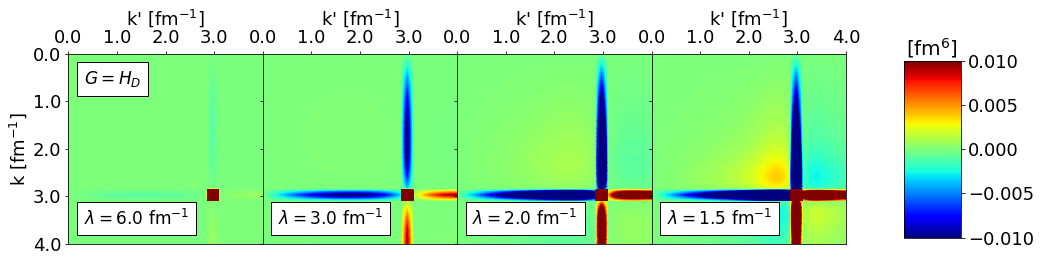

In [10]:
# Plot SRG-evolved momentum projection operators


# AV18 with Wegner
momentum_projection_contours(q, 10, '3S1', 30.0, 4.0, ntot, 'Wegner', lambda_array)

# EM N3LO non-local potential at cutoff of 500 MeV
# Wegner
momentum_projection_contours(q, 10, '3S1', kmax, kmid, ntot, 'Wegner', lambda_array)
# Block-diagonal
momentum_projection_contours(q, 10, '3S1', kmax, kmid, ntot, 'Block-diag', lambda_array)
# Wegner but for q = 0.3 fm^-1
momentum_projection_contours(0.3, 10, '3S1', kmax, kmid, ntot, 'Wegner', lambda_array)
# Wegner but in the 1S0 channel
momentum_projection_contours(q, 10, '1S0', kmax, kmid, ntot, 'Wegner', lambda_array)
# Wegner but in the 1P1 channel
momentum_projection_contours(q, 10, '1P1', kmax, kmid, ntot, 'Wegner', lambda_array)
# TESTING
#momentum_projection_contours(q, 10, '3S1', 30.0, 4.0, ntot, 'Wegner', lambda_array)

# RKE N3LO semi-local potential at cutoff of 450 MeV
# Wegner
momentum_projection_contours(q, 106, '3S1', kmax, kmid, ntot, 'Wegner', lambda_array)
# Block-diagonal
momentum_projection_contours(q, 106, '3S1', kmax, kmid, ntot, 'Block-diag', lambda_array)
# Wegner but for q = 0.3 fm^-1
momentum_projection_contours(0.3, 106, '3S1', kmax, kmid, ntot, 'Wegner', lambda_array)
# Wegner but in the 1S0 channel
momentum_projection_contours(q, 106, '1S0', kmax, kmid, ntot, 'Wegner', lambda_array)
# Wegner but in the 1P1 channel
momentum_projection_contours(q, 106, '1P1', kmax, kmid, ntot, 'Wegner', lambda_array)

# Gezerlis et al N2LO local at cutoff 1.0 fm
# Wegner
momentum_projection_contours(q, 222, '3S1', kmax, kmid, ntot, 'Wegner', lambda_array)
# Block-diagonal
momentum_projection_contours(q, 222, '3S1', kmax, kmid, ntot, 'Block-diag', lambda_array)
# Wegner but for q = 0.3 fm^-1
momentum_projection_contours(0.3, 222, '3S1', kmax, kmid, ntot, 'Wegner', lambda_array)
# Wegner but in the 1S0 channel
momentum_projection_contours(q, 222, '1S0', kmax, kmid, ntot, 'Wegner', lambda_array)
# Wegner but in the 1P1 channel
momentum_projection_contours(q, 222, '1P1', kmax, kmid, ntot, 'Wegner', lambda_array)

In [11]:
# Plot diagonal and off-diagonal matrix elements of SRG-evolved momentum projection operators


# Diagonal matrix elements for SRG-evolved momentum projection operators at q = 3 fm^-1
# 1S0
#momentum_projection_slices('diag', q, '1S0', lambda_array, em_n3lo, rke_n3lo, gez_n2lo)
# 3S1
#momentum_projection_slices('diag', q, '3S1', lambda_array, em_n3lo, rke_n3lo, gez_n2lo)
# 1P1
#momentum_projection_slices('diag', q, '1P1', lambda_array, em_n3lo, rke_n3lo, gez_n2lo)
# 3S1 but q = 0.3 fm^-1
#momentum_projection_slices('diag', 0.3, '3S1', lambda_array, em_n3lo, rke_n3lo, gez_n2lo)

# Far off-diagonal matrix elements for SRG-evolved momentum projection operators at q = 3 fm^-1
# 1S0
#momentum_projection_slices('off-diag', q, '1S0', lambda_array, em_n3lo, rke_n3lo, gez_n2lo)
# 3S1
#momentum_projection_slices('off-diag', q, '3S1', lambda_array, em_n3lo, rke_n3lo, gez_n2lo)
# 1P1 off-diagonals are mostly zero

# Vary q and fix lambda = 1.5 fm^-1
q_array = np.array( (0.5, 1.0, 2.0, 3.0) )
#momentum_projection_slices_vary_q('diag', q_array, '3S1', lambda_array[-1], em_n3lo, rke_n3lo, gez_n2lo)

In [12]:
# Plot SRG-evolved momentum projection integrands


# EM N3LO non-local potential at cutoff of 500 MeV
# Wegner
#momentum_projection_integrand_contours(q, 10, kmax, kmid, ntot, 'Wegner', lambda_array)
# Block-diagonal
#momentum_projection_integrand_contours(q, 10, kmax, kmid, ntot, 'Block-diag', lambda_array)
# Wegner but for q = 0.3 fm^-1
#momentum_projection_integrand_contours(0.3, 10, kmax, kmid, ntot, 'Wegner', lambda_array)

# RKE N3LO semi-local potential at cutoff of 450 MeV
# Wegner
#momentum_projection_integrand_contours(q, 106, kmax, kmid, ntot, 'Wegner', lambda_array)
# Block-diagonal
#momentum_projection_integrand_contours(q, 106, kmax, kmid, ntot, 'Block-diag', lambda_array)
# Wegner but for q = 0.3 fm^-1
#momentum_projection_integrand_contours(0.3, 106, kmax, kmid, ntot, 'Wegner', lambda_array)

# Gezerlis et al N2LO local at cutoff 1.0 fm
# Wegner
#momentum_projection_integrand_contours(q, 222, kmax, kmid, ntot, 'Wegner', lambda_array)
# Block-diagonal
#momentum_projection_integrand_contours(q, 222, kmax, kmid, ntot, 'Block-diag', lambda_array)
# Wegner but for q = 0.3 fm^-1
#momentum_projection_integrand_contours(0.3, 222, kmax, kmid, ntot, 'Wegner', lambda_array)

In [13]:
# Plot diagonal and off-diagonal matrix elements of SRG-evolved momentum projection integrands


# Diagonal matrix elements for SRG-evolved momentum projection operators at q = 3 fm^-1
# 3S1
#momentum_projection_integrand_slices('diag', q, lambda_array, em_n3lo, rke_n3lo, gez_n2lo)
# 3S1 but q = 0.3 fm^-1
#momentum_projection_integrand_slices('diag', 0.3, lambda_array, em_n3lo, rke_n3lo, gez_n2lo)

# Far off-diagonal matrix elements for SRG-evolved momentum projection operators at q = 3 fm^-1
# 3S1
#momentum_projection_integrand_slices('off-diag', q, lambda_array, em_n3lo, rke_n3lo, gez_n2lo)

In [14]:
# Plot SRG-evolved r^2 operators


# EM N3LO non-local potential
# Wegner
#r2_contours(10, channel, 30.0, 4.0, ntot, 'Wegner')

In [15]:
# Plot diagonal and off-diagonal matrix elements of SRG-evolved r^2 operators